# Tropical cyclones and sea surface temperatures: A preliminary analysis

Modelling studies performed by Revell and Goulter (1986) and Nicholls (1990) suggest a strong relationship between the ENSO phase and 
tropical cyclone occurrence and genesis sites. This notebook will seek to analyse this relationship by linking our sea surface temperature and cyclone occurrence datasets 

In [2]:
# %matplotlib inline
import numpy as np
import pandas as pd
from datetime import datetime 
import seaborn as sns
from matplotlib import pyplot as plt
import xarray as xr
from netCDF4 import Dataset

import cartopy.crs as ccrs
import cartopy.io.shapereader as shpreader


from utils.globals import SI_MIN, SI_MAX, SP_MIN, SP_MAX
from utils.cyclone_utils import get_cyclone_data, time_to_season

In [3]:
# IMPORT OUR MONTHLY MEAN SST DATA
monthly_avg_ssts = xr.open_dataset('../SST_data/Historical/sst.mon.mean.nc', engine='netcdf4')
monthly_avg_ssts


<xarray.Dataset>
Dimensions:  (time: 499, lat: 720, lon: 1440)
Coordinates:
  * time     (time) datetime64[ns] 1981-09-01 1981-10-01 ... 2023-03-01
  * lat      (lat) float32 -89.88 -89.62 -89.38 -89.12 ... 89.38 89.62 89.88
  * lon      (lon) float32 0.125 0.375 0.625 0.875 ... 359.1 359.4 359.6 359.9
Data variables:
    sst      (time, lat, lon) float32 ...
Attributes:
    Conventions:    CF-1.5
    title:          NOAA/NCEI 1/4 Degree Daily Optimum Interpolation Sea Surf...
    institution:    NOAA/National Centers for Environmental Information
    source:         NOAA/NCEI https://www.ncei.noaa.gov/data/sea-surface-temp...
    References:     https://www.psl.noaa.gov/data/gridded/data.noaa.oisst.v2....
    dataset_title:  NOAA Daily Optimum Interpolation Sea Surface Temperature
    version:        Version 2.1
    comment:        Reynolds, et al.(2007) Daily High-Resolution-Blended Anal...

In [4]:



relevant_df = get_cyclone_data()
one_per_id = relevant_df.drop_duplicates(subset='id')
one_per_id



,id,Time,latitude,longitude,Speed(knots),category,season
0,1,1981-07-25 12:00:00,-11.8,86.7,20,1,1981-1982
13,2,1981-10-21 06:00:00,-8.0,84.6,40,2,1981-1982
38,3,1981-11-03 18:00:00,-8.6,92.9,55,2,1981-1982
71,4,1981-12-05 00:00:00,-11.9,125.0,45,1,1981-1982
74,5,1981-12-29 00:00:00,-9.5,78.8,20,1,1981-1982
...,...,...,...,...,...,...,...
30412,998,2019-04-03 06:00:00,-8.2,132.3,20,1,2018-2019
30455,999,2019-04-21 18:00:00,-4.0,79.3,20,3,2018-2019
30456,1000,2019-04-21 18:00:00,-9.7,52.7,20,4,2018-2019
30512,1001,2019-05-06 12:00:00,-5.6,129.9,20,1,2018-2019


In [5]:
si_ids = one_per_id.loc[(one_per_id.loc[:, 'longitude'] > SI_MIN) & (one_per_id.loc[:, 'longitude'] < SI_MAX)]
sp_ids = one_per_id.loc[(one_per_id.loc[:, 'longitude'] > SP_MIN) & (one_per_id.loc[:, 'longitude'] < SP_MAX)]

### Let's inspect seasonal temperature anomalies and check how this effects cyclones in the South Pacific 

In [6]:
monthly_anomaly = monthly_avg_ssts.groupby('time.month') - monthly_avg_ssts.groupby('time.month').mean()
monthly_anomaly

<xarray.Dataset>
Dimensions:  (time: 499, lat: 720, lon: 1440)
Coordinates:
  * time     (time) datetime64[ns] 1981-09-01 1981-10-01 ... 2023-03-01
  * lat      (lat) float32 -89.88 -89.62 -89.38 -89.12 ... 89.38 89.62 89.88
  * lon      (lon) float32 0.125 0.375 0.625 0.875 ... 359.1 359.4 359.6 359.9
    month    (time) int64 9 10 11 12 1 2 3 4 5 6 7 ... 5 6 7 8 9 10 11 12 1 2 3
Data variables:
    sst      (time, lat, lon) float32 nan nan nan nan ... -0.04729 -0.047 -0.047

In [105]:
# take average of this in the tropical region and get a 12 month running mean

## NOTE: THIS IS A BIT OF A POOR ESTIMATE BC WE ONLY HAVE DATA FOR ONE DAY PER MONTH

## TODO: IS this even the right thing to calculate? LOOK AT THE CLIMATE LITERATURE TO SEE
##       what is important....
si_anom = monthly_anomaly.sel(lon=slice(SI_MIN, SI_MAX))

si_avg_anomaly = si_anom.sel(lat=slice(-5,0)).mean(dim=['lon', 'lat'])
si_avg_anomaly['rolling'] = si_avg_anomaly['sst'].rolling(time=12).mean().dropna(dim='time')
si_avg_anomaly_df = si_avg_anomaly.to_dataframe()
si_avg_anomaly_df.columns = si_avg_anomaly_df.columns.get_level_values(0)
si_avg_anomaly_df.reset_index(inplace=True)
si_avg_anomaly_df['season'] = si_avg_anomaly_df['time'].apply(time_to_season)
si_avg_anomaly_df


# # then get the mean anomaly in a season
# # TODO: more weight on in-season temperature anomalies?
# avg_anomaly_df['avg_season_anomaly'] = avg_anomaly_df.groupby('season')['sst'].transform('mean')
# avg_anomaly_df


,time,month,sst,rolling,season
0,1981-09-01,9,-0.099361,NaN,1981-1982
1,1981-10-01,10,0.103304,NaN,1981-1982
2,1981-11-01,11,-0.319704,NaN,1981-1982
3,1981-12-01,12,-0.478285,NaN,1981-1982
4,1982-01-01,1,-0.336919,NaN,1981-1982
...,...,...,...,...,...
494,2022-11-01,11,0.021895,0.276283,2022-2023
495,2022-12-01,12,0.055542,0.253950,2022-2023
496,2023-01-01,1,-0.000805,0.209848,2022-2023
497,2023-02-01,2,-0.238834,0.186732,2022-2023


In [106]:
sp_anom = monthly_anomaly.sel(lon = slice(SP_MIN,SP_MAX))

sp_avg_anomaly = sp_anom.sel(lat=slice(-5,0)).mean(dim=['lon', 'lat'])
sp_avg_anomaly['rolling'] = sp_avg_anomaly['sst'].rolling(time=12).mean().dropna(dim='time')
sp_avg_anomaly_df = sp_avg_anomaly.to_dataframe()
sp_avg_anomaly_df.columns = sp_avg_anomaly_df.columns.get_level_values(0)
sp_avg_anomaly_df.reset_index(inplace=True)
sp_avg_anomaly_df['season'] = sp_avg_anomaly_df['time'].apply(time_to_season)
sp_avg_anomaly_df


,time,month,sst,rolling,season
0,1981-09-01,9,-0.299243,NaN,1981-1982
1,1981-10-01,10,-0.234323,NaN,1981-1982
2,1981-11-01,11,-0.352020,NaN,1981-1982
3,1981-12-01,12,-0.173186,NaN,1981-1982
4,1982-01-01,1,-0.054511,NaN,1981-1982
...,...,...,...,...,...
494,2022-11-01,11,-0.765189,-0.677751,2022-2023
495,2022-12-01,12,-0.610612,-0.655224,2022-2023
496,2023-01-01,1,-0.395866,-0.634425,2022-2023
497,2023-02-01,2,-0.088762,-0.591549,2022-2023


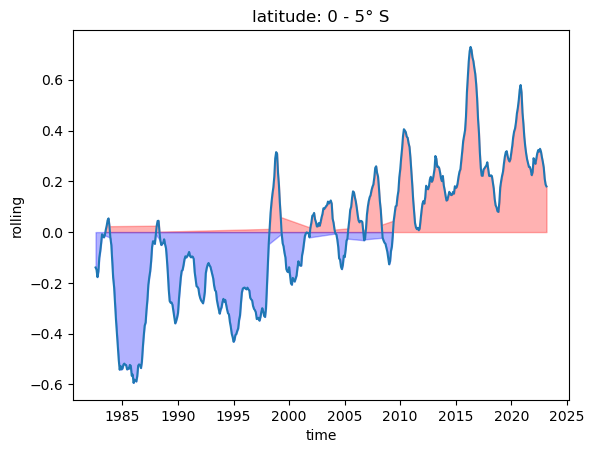

In [107]:
ax = sns.lineplot(data = si_avg_anomaly_df, y= 'rolling', x='time')
line_obj = ax.lines[0]
x1 = line_obj.get_xydata()[:,0]
y1 = line_obj.get_xydata()[:,1]

x1_pos = x1[y1 > 0]
y1_pos = y1[y1 > 0]

x1_neg = x1[y1 < 0]
y1_neg = y1[y1 < 0]

ax.fill_between(x1_pos,y1_pos, color="red", alpha=0.3)
ax.fill_between(x1_neg,y1_neg, color="blue", alpha=0.3)
ax.set_title('latitude: 0 - 5' + u'\N{DEGREE SIGN}' + ' S')
fig = ax.get_figure()
fig.savefig('anomaly_si_5deg')

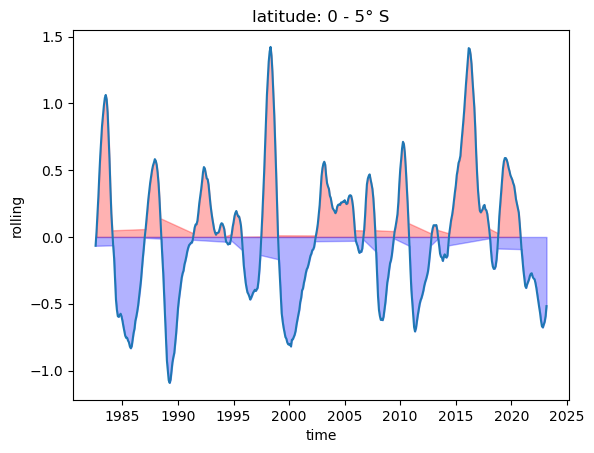

In [108]:
ax = sns.lineplot(data = sp_avg_anomaly_df, y= 'rolling', x='time')
line_obj = ax.lines[0]
x1 = line_obj.get_xydata()[:,0]
y1 = line_obj.get_xydata()[:,1]

x1_pos = x1[y1 > 0]
y1_pos = y1[y1 > 0]

x1_neg = x1[y1 < 0]
y1_neg = y1[y1 < 0]

ax.fill_between(x1_pos,y1_pos, color="red", alpha=0.3)
ax.fill_between(x1_neg,y1_neg, color="blue", alpha=0.3)
ax.set_title('latitude: 0 - 5' + u'\N{DEGREE SIGN}' + ' S')
fig = ax.get_figure()
fig.savefig('anomaly_sp_5deg')

In [109]:
# OBTAIN A DATAFRAME OF AVERAGE ANOMALY WITHIN A SEASON
sp_avg_anomaly_df['Season Anomaly'] = sp_avg_anomaly_df.groupby('season')['rolling'].transform('mean')
sp_season_anomaly_df = sp_avg_anomaly_df.drop_duplicates(subset='season').dropna()
sp_season_anomaly_df



,time,month,sst,rolling,season,Season Anomaly
22,1983-07-01,7,0.333659,1.063174,1983-1984,0.331025
34,1984-07-01,7,-0.561391,-0.544758,1984-1985,-0.645174
46,1985-07-01,7,-0.815689,-0.775406,1985-1986,-0.708955
58,1986-07-01,7,-0.112008,-0.453052,1986-1987,-0.054193
70,1987-07-01,7,0.614050,0.405637,1987-1988,0.454152
82,1988-07-01,7,-1.218974,-0.012701,1988-1989,-0.703305
94,1989-07-01,7,-0.427537,-0.940133,1989-1990,-0.600035
106,1990-07-01,7,-0.188940,-0.252494,1990-1991,-0.097324
118,1991-07-01,7,0.327024,0.069100,1991-1992,0.284085
130,1992-07-01,7,-0.115145,0.475064,1992-1993,0.236537


In [116]:
si_avg_anomaly_df['Season Anomaly'] = si_avg_anomaly_df.groupby('season')['rolling'].transform('last')
si_season_anomaly_df = si_avg_anomaly_df.drop_duplicates(subset='season').dropna()
si_season_anomaly_df

,time,month,sst,rolling,season,Season Anomaly
22,1983-07-01,7,0.195032,0.008175,1983-1984,-0.344661
34,1984-07-01,7,-0.435006,-0.397164,1984-1985,-0.540851
46,1985-07-01,7,-0.404073,-0.538273,1985-1986,-0.526355
58,1986-07-01,7,-0.339559,-0.520979,1986-1987,-0.177786
70,1987-07-01,7,-0.056564,-0.154203,1987-1988,-0.035418
82,1988-07-01,7,-0.244116,-0.051047,1988-1989,-0.276996
94,1989-07-01,7,-0.352555,-0.286032,1989-1990,-0.148643
106,1990-07-01,7,-0.131531,-0.130224,1990-1991,-0.106384
118,1991-07-01,7,-0.732999,-0.156506,1991-1992,-0.233755
130,1992-07-01,7,0.127749,-0.162026,1992-1993,-0.233678


### Cyclone category distributions for different levels of SST anomaly 

In [117]:
QUANTILES = [0, .25, 0.5, 0.75, 1]

# TODO: do the SI/SP comparison a bit more nicely
sp_quantiles = sp_season_anomaly_df['Season Anomaly'].quantile(QUANTILES).to_list()
si_quantiles = si_season_anomaly_df['Season Anomaly'].quantile(QUANTILES).to_list()

print(sp_quantiles)
print(si_quantiles)

[-0.7671658992767334, -0.30472396314144135, 0.013167422264814377, 0.26799485087394714, 1.1252127885818481]
[-0.5408511757850647, -0.1987123265862465, 0.028628231026232243, 0.17424467951059341, 0.7165617346763611]


/var/folders/nk/f4_nbwvd0_vgzc0m31k7tc6m0000gn/T/ipykernel_55691/1834031283.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sp_ids.loc[:,'Anomaly Quantile'] = None
/var/folders/nk/f4_nbwvd0_vgzc0m31k7tc6m0000gn/T/ipykernel_55691/1834031283.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sp_ids.loc[:, 'Anomaly Quantile'] = sp_ids.apply(lambda row: f'{i*.25} - {(i+1)*.25}' if row['season'] in seasons else row['Anomaly Quantile'], axis=1)
/var/folders/nk/f4_nbwvd0_vgzc0m31k7tc6m0000gn/T/ipykernel_5569

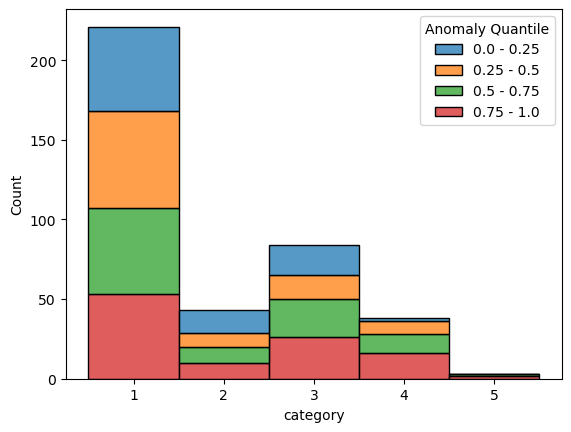

In [118]:
legend_strings = []
sp_ids.loc[:,'Anomaly Quantile'] = None
for i in range(len(QUANTILES) - 1):
        sp_filtered_seasons = sp_season_anomaly_df.loc[
                (sp_season_anomaly_df['Season Anomaly'] >= sp_quantiles[i]) 
                & (sp_season_anomaly_df['Season Anomaly'] <= sp_quantiles[i + 1])]
        
        
        seasons = sp_filtered_seasons['season'].to_list()
        legend_strings.append(f'{i*.25} - {(i+1)*.25}')
        sp_ids.loc[:, 'Anomaly Quantile'] = sp_ids.apply(lambda row: f'{i*.25} - {(i+1)*.25}' if row['season'] in seasons else row['Anomaly Quantile'], axis=1)

ax = sns.histplot(sp_ids, x='category', discrete=True, hue='Anomaly Quantile', multiple='stack', hue_order=legend_strings)
fig = ax.get_figure()
fig.savefig('./media/cyclone_plot/sp_anomaly_cyclones.png')
plt.show()

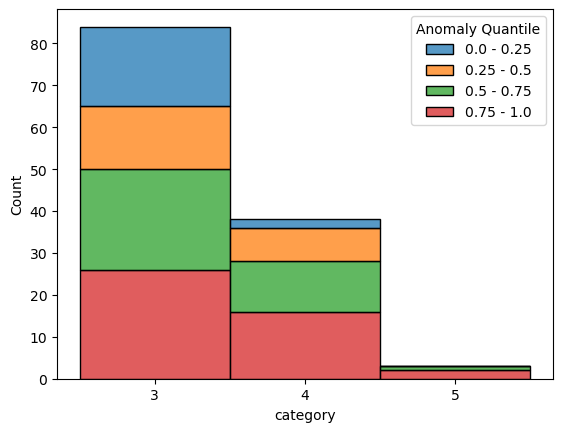

In [119]:
import matplotlib.ticker as ticker
# what about for more extreme cyclones? zoom in a bit
sp_extreme = sp_ids[sp_ids['category'] >= 3]

ax = sns.histplot(sp_extreme, x='category', discrete=True, hue='Anomaly Quantile', multiple='stack', hue_order=legend_strings)
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
fig = ax.get_figure()
fig.savefig('./media/cyclone_plot/sp_severe_anomaly_cyclones.png')
plt.show()

/var/folders/nk/f4_nbwvd0_vgzc0m31k7tc6m0000gn/T/ipykernel_55691/4084544464.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  si_ids.loc[:,'Anomaly Quantile'] = None
/var/folders/nk/f4_nbwvd0_vgzc0m31k7tc6m0000gn/T/ipykernel_55691/4084544464.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  si_ids.loc[:, 'Anomaly Quantile'] = si_ids.apply(lambda row: f'{i*.25} - {(i+1)*.25}' if row['season'] in seasons else row['Anomaly Quantile'], axis=1)
/var/folders/nk/f4_nbwvd0_vgzc0m31k7tc6m0000gn/T/ipykernel_55691

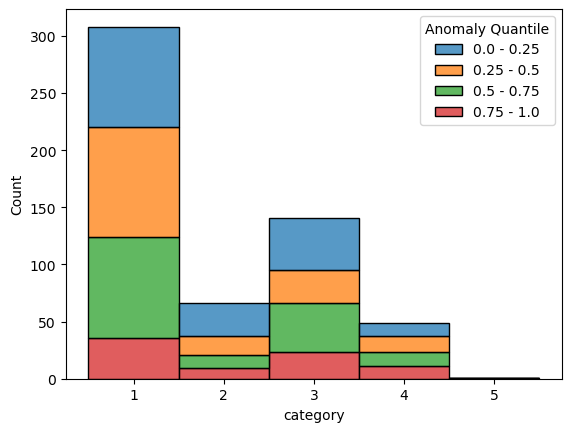

In [120]:
si_ids.loc[:,'Anomaly Quantile'] = None
for i in range(len(QUANTILES) - 1):
        si_filtered_seasons = si_season_anomaly_df.loc[
                (si_season_anomaly_df['Season Anomaly'] >= si_quantiles[i]) 
                & (si_season_anomaly_df['Season Anomaly'] <= si_quantiles[i + 1])]
        
        
        seasons = si_filtered_seasons['season'].to_list()
        si_ids.loc[:, 'Anomaly Quantile'] = si_ids.apply(lambda row: f'{i*.25} - {(i+1)*.25}' if row['season'] in seasons else row['Anomaly Quantile'], axis=1)

ax =sns.histplot(si_ids, x='category', discrete=True, hue='Anomaly Quantile', multiple='stack', hue_order=legend_strings)
fig = ax.get_figure()
fig.savefig('./media/cyclone_plot/si_anomaly_cyclones.png')
plt.show()

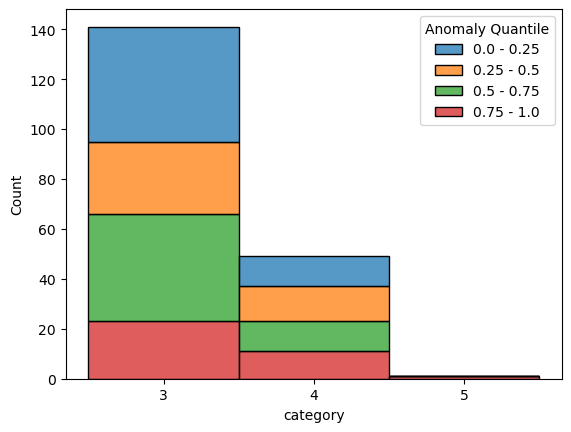

In [121]:
import matplotlib.ticker as ticker
# what about for more extreme cyclones? zoom in a bit
si_extreme = si_ids[si_ids['category'] >= 3]

ax = sns.histplot(si_extreme, x='category', discrete=True, hue='Anomaly Quantile', multiple='stack', hue_order=legend_strings)
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
fig = ax.get_figure()
fig.savefig('./media/cyclone_plot/si_severe_anomaly_cyclones.png')
plt.show()

### Cyclones in anomolous SST Seasons
Note that my metric for 'anomalous' is completely arbitrary and I have just gone with this

In [ ]:
sp_lower_p = sp_avg_anomaly_df['rolling'].quantile(.25)
sp_higher_p = sp_avg_anomaly_df['rolling'].quantile(.75)

print(sp_lower_p)
print(sp_higher_p)

-0.15996748
0.1518833


In [ ]:
si_lower_p = si_avg_anomaly_df['rolling'].quantile(.25)
si_higher_p = si_avg_anomaly_df['rolling'].quantile(.75)

print(si_lower_p)
print(si_higher_p)

-0.1899665
0.20087785


In [ ]:
sp_lower_p_filtered = sp_avg_anomaly_df.loc[sp_avg_anomaly_df.loc[:,'rolling'] < sp_lower_p]
sp_lower_p_seasons = sp_lower_p_filtered['season']
sp_higher_p_filtered = sp_avg_anomaly_df.loc[sp_avg_anomaly_df.loc[:,'rolling'] > sp_higher_p]
sp_higher_p_seasons = sp_higher_p_filtered['season']

In [ ]:
si_lower_p_filtered =  si_avg_anomaly_df.loc[si_avg_anomaly_df.loc[:,'rolling'] < si_lower_p]
si_lower_p_seasons =   si_lower_p_filtered['season']
si_higher_p_filtered = si_avg_anomaly_df.loc[si_avg_anomaly_df.loc[:,'rolling'] > si_higher_p]
si_higher_p_seasons =  si_higher_p_filtered['season']

/Users/albertdemskoy/mambaforge/envs/climateProjectEnv/lib/python3.11/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/albertdemskoy/mambaforge/envs/climateProjectEnv/lib/python3.11/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(


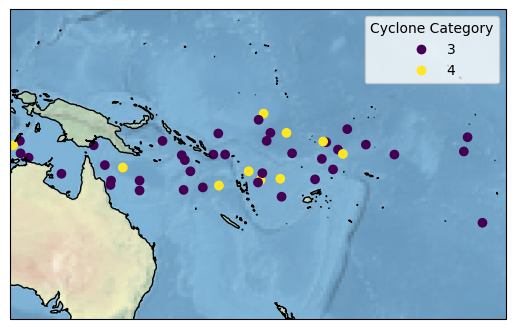

In [ ]:
sp_lower_p_cyclones = sp_ids.loc[sp_ids.loc[:, 'season'].isin(sp_lower_p_seasons)]
sp_lower_p_severe = sp_lower_p_cyclones[sp_lower_p_cyclones['category'] >= 3]
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude= (210 - 130)/2))
ax.set_extent([130, 210 , -30,10])
ax.coastlines()
ax.stock_img()

scatter = plt.scatter(x=sp_lower_p_severe['longitude'], y=sp_lower_p_severe['latitude'], cmap='viridis',c=sp_lower_p_severe['category'], transform=ccrs.PlateCarree())
ax.legend(*scatter.legend_elements(),title="Cyclone Category")
plt.show()

/Users/albertdemskoy/mambaforge/envs/climateProjectEnv/lib/python3.11/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/albertdemskoy/mambaforge/envs/climateProjectEnv/lib/python3.11/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(


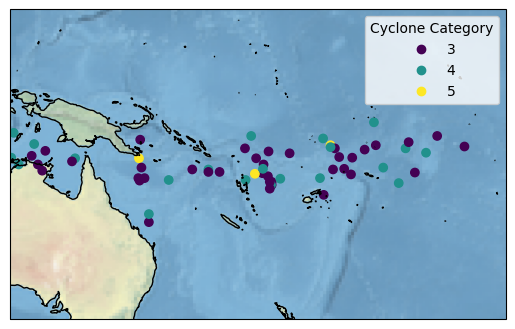

In [ ]:
sp_higher_p_cyclones = sp_ids.loc[sp_ids.loc[:, 'season'].isin(sp_higher_p_seasons)]
sp_higher_p_severe = sp_higher_p_cyclones[sp_higher_p_cyclones['category'] >= 3]
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude= (210 - 130)/2))
ax.set_extent([130, 210 , -30,10])
ax.coastlines()
ax.stock_img()

scatter = plt.scatter(x=sp_higher_p_severe['longitude'], y=sp_higher_p_severe['latitude'], cmap='viridis',c=sp_higher_p_severe['category'], transform=ccrs.PlateCarree())
ax.legend(*scatter.legend_elements(),title="Cyclone Category")
# NOTE THAT WE SEE A HIGHER PROPORTION OF CAT4 cyclones 

plt.show()

/Users/albertdemskoy/mambaforge/envs/climateProjectEnv/lib/python3.11/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/albertdemskoy/mambaforge/envs/climateProjectEnv/lib/python3.11/site-packages/shapely/predicates.py:798: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)


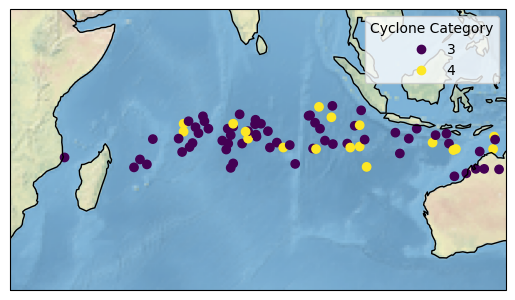

In [ ]:
si_lower_p_cyclones = si_ids.loc[si_ids.loc[:, 'season'].isin(si_lower_p_seasons)]
si_lower_p_severe = si_lower_p_cyclones[si_lower_p_cyclones['category'] >= 3]
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude= (130 - 30)/2))
ax.set_extent([30, 130 , -30,10])
ax.coastlines()
ax.stock_img()

scatter = plt.scatter(x=si_lower_p_severe['longitude'], y=si_lower_p_severe['latitude'], cmap='viridis',c=si_lower_p_severe['category'], transform=ccrs.PlateCarree())
ax.legend(*scatter.legend_elements(),title="Cyclone Category")

plt.show()

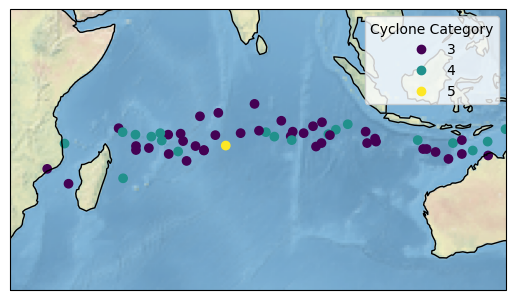

In [ ]:
si_higher_p_cyclones = si_ids.loc[si_ids.loc[:, 'season'].isin(si_higher_p_seasons)]
si_higher_p_severe = si_higher_p_cyclones[si_higher_p_cyclones['category'] >= 3]
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude= (130 - 30)/2))
ax.set_extent([30, 130 , -30,10])
ax.coastlines()
ax.stock_img()

scatter = plt.scatter(x=si_higher_p_severe['longitude'], y=si_higher_p_severe['latitude'], cmap='viridis',c=si_higher_p_severe['category'], transform=ccrs.PlateCarree())
ax.legend(*scatter.legend_elements(),title="Cyclone Category")
# NOTE THAT WE SEE A HIGHER PROPORTION OF CAT4 cyclones 

plt.show()

### A Note
The literature mentions that the North Pacific and the Atlantic ocean have had a much greater research emphasis than the South Pacific. It also seems that, in turn, the South Pacific has had much more research focus than the South Indian Ocean. 

### TODO:
- Analyse the SST characteristics of the 'worst' cyclone seasons we have on record.
- Analyse the impact of SST variation on trends in cyclone tracks